# Imports

In [1]:
from abacusnbody.data.compaso_halo_catalog import CompaSOHaloCatalog
from abacusnbody.data.read_abacus import read_asdf
import h5py
import os

import matplotlib.pyplot as plt
from matplotlib import ticker, cm, colors
import matplotlib.colors as mcolors

import numpy as np
import pandas as pd

from scipy.spatial import KDTree, cKDTree
from scipy.spatial.distance import cdist
from scipy.interpolate import griddata, UnivariateSpline, interp1d
from scipy.integrate import quad
from scipy.optimize import linear_sum_assignment, curve_fit

from collections import Counter
from pycorr import TwoPointCorrelationFunction, TwoPointCounter

import psutil
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
import gc
import pickle

import importlib
import functions
importlib.reload(functions)
from functions import *

## Halos

In [2]:
compaso_dir = '/global/cfs/cdirs/desi/cosmosim/Abacus/AbacusSummit_highbase_c000_ph100'

str_z = 'z0.500'
cols = ['id', 'x_L2com', 'v_L2com', 'N', 'r100_L2com']

path_to_sim = os.path.join(compaso_dir, "halos", str_z)
hcat = CompaSOHaloCatalog(path_to_sim, fields=cols, cleaned=True)

In [3]:
## CompaSo

boxsize_cs = hcat.header['BoxSize']
print("Box size CompaSo:", boxsize_cs)

Mhalos_CS =  hcat.header['ParticleMassHMsun']*hcat.halos['N']

hcat_pos = hcat.halos

positions_cs = np.array(hcat_pos['x_L2com'])
positions_cs = positions_cs.astype(np.float64)
positions_cs = (positions_cs + boxsize_cs / 2) % boxsize_cs

radii_cs = np.array(hcat_pos['r100_L2com'])

Box size CompaSo: 1000.0


In [4]:
## Rockstar

data = np.load('/pscratch/sd/g/guittonm/rockstar_parent_halos.npz')

Mhalos_RS = data['masses']
ids_RS = data['ids']
positions_RS = data['positions']
velocities_RS = data['velocities']

file_path_rs = "/global/cfs/cdirs/desi/cosmosim/Abacus/supplemental/AbacusSummit_highbase_c000_ph100/rockstar/z0.500/rockstar.cfg"
boxsize_rs = get_variable(file_path_rs, name='BOX_SIZE')
print(f"Box size Rockstar: {boxsize_rs}")

Box size Rockstar: 1000


In [5]:
print(f"Nombre de halos Rockstar : {len(Mhalos_RS):,}".replace(',', ' '))
print(f"Nombre de halos CompaSO  : {len(Mhalos_CS):,}".replace(',', ' '))

Nombre de halos Rockstar : 93 318 302
Nombre de halos CompaSO  : 49 869 950


In [6]:
def filter_nested_halos(positions, radii, masses, boxsize=None, verbose=True):
    """
    Élimine les halos contenus dans un halo plus massif (centre-à-centre < rayon du plus gros halo).

    Args:
        positions (np.ndarray): (N, 3) positions des halos
        radii (np.ndarray): (N,) rayon utilisé pour exclusion (par exemple r100_L2com)
        masses (np.ndarray): (N,) masses des halos
        boxsize (float, optional): taille de la boîte (pour périodicité). Si None, pas de périodicité.
        verbose (bool): Affiche les stats si True

    Returns:
        isolated_mask (np.ndarray): booléen (N,), True si le halo est isolé
    """
    N = len(positions)
    assert positions.shape == (N, 3)
    assert radii.shape == (N,)
    assert masses.shape == (N,)

    # Trier par masse décroissante
    sorted_idx = np.argsort(-masses)
    positions = positions[sorted_idx]
    radii = radii[sorted_idx]
    masses = masses[sorted_idx]

    # KDTree
    tree = cKDTree(positions, boxsize=boxsize)

    contained = np.zeros(N, dtype=bool)

    for i in range(N):
        if contained[i]:
            continue  # déjà inclus par un halo plus massif

        # Trouver tous les voisins dans le rayon du halo i
        neighbors = tree.query_ball_point(positions[i], r=radii[i])

        # Marquer tous les halos moins massifs (index > i) comme contenus
        for j in neighbors:
            if j > i:
                contained[j] = True

        # Nettoyage périodique mémoire si N est grand
        if i % 10000 == 0:
            process = psutil.Process()
            ram_used = process.memory_info().rss / 1e9
            print(f"Halo {i:>7} / {N:>7} — RAM utilisée : {ram_used:.2f} GB")
            gc.collect()

    # Création du masque isolé
    isolated_mask = ~contained

    if verbose:
        print(f"Total halos : {N:,}".replace(',', ' '))
        print(f"Isolated halos : {np.sum(isolated_mask):,}".replace(',', ' '))
        print(f"Nested halos removed : {np.sum(contained):,}".replace(',', ' '))

    # Retourner le masque dans l’ordre initial (non trié)
    reindexed_mask = np.zeros_like(isolated_mask)
    reindexed_mask[sorted_idx] = isolated_mask

    return reindexed_mask

In [7]:
isolated_mask = filter_nested_halos(positions_cs, radii_cs, Mhalos_CS, boxsize=boxsize_cs, verbose=True)
positions_cs = positions_cs[isolated_mask]

Halo       0 / 49869950 — RAM utilisée : 11.24 GB
Halo   10000 / 49869950 — RAM utilisée : 11.24 GB
Halo   20000 / 49869950 — RAM utilisée : 11.24 GB
Halo   30000 / 49869950 — RAM utilisée : 11.24 GB
Halo   40000 / 49869950 — RAM utilisée : 11.24 GB
Halo   50000 / 49869950 — RAM utilisée : 11.24 GB
Halo   60000 / 49869950 — RAM utilisée : 11.24 GB
Halo   70000 / 49869950 — RAM utilisée : 11.24 GB
Halo   80000 / 49869950 — RAM utilisée : 11.24 GB
Halo   90000 / 49869950 — RAM utilisée : 11.24 GB
Halo  100000 / 49869950 — RAM utilisée : 11.24 GB
Halo  110000 / 49869950 — RAM utilisée : 11.24 GB
Halo  120000 / 49869950 — RAM utilisée : 11.24 GB
Halo  130000 / 49869950 — RAM utilisée : 11.24 GB
Halo  140000 / 49869950 — RAM utilisée : 11.24 GB
Halo  150000 / 49869950 — RAM utilisée : 11.24 GB
Halo  160000 / 49869950 — RAM utilisée : 11.24 GB
Halo  170000 / 49869950 — RAM utilisée : 11.24 GB
Halo  180000 / 49869950 — RAM utilisée : 11.24 GB
Halo  190000 / 49869950 — RAM utilisée : 11.24 GB


In [8]:
Mhalos_CS = Mhalos_CS[isolated_mask]
radii_cs = radii_cs[isolated_mask]

# Mass study

In [9]:
colors_list = ['green', 'red'] 
colors_ratio=['blue']
labels_name = ['CompaSO', 'Rockstar']
labels_scale = ['Linear', 'Log']
labels_ratio = ['Rockstar / Compaso']

## Bins

In [10]:
# Linear bins
bins = np.histogram_bin_edges(np.concatenate([Mhalos_RS, Mhalos_CS]), bins=50)

# Show bins
min_min_mass = min(Mhalos_RS.min(), Mhalos_CS.min())
max__max_mass = max(Mhalos_RS.max(), Mhalos_CS.max())

bins_log_tot = np.logspace(np.log10(min_min_mass), np.log10(max__max_mass), num=50)
bins_log_centers_tot = 0.5 * (bins_log_tot[:-1] + bins_log_tot[1:])

# Logarithmic bins
min_mass = max(Mhalos_RS.min(), Mhalos_CS.min())
max_mass = min(Mhalos_RS.max(), Mhalos_CS.max())

bins_log = np.logspace(np.log10(min_mass), np.log10(max_mass), num=30)
bins_log_centers = 0.5 * (bins_log[:-1] + bins_log[1:])

print(f"Minimum log bins : {bins_log[0]:.2e}")
print(f"Max log bins : {bins_log[29]:.2e}")

Minimum log bins : 4.22e+09
Max log bins : 1.17e+15


/tmp/ipykernel_886580/4050996196.py:8: RuntimeWarning: divide by zero encountered in log10
  bins_log_tot = np.logspace(np.log10(min_min_mass), np.log10(max__max_mass), num=50)
/global/homes/g/guittonm/.conda/envs/desi-env/lib/python3.11/site-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
/global/homes/g/guittonm/.conda/envs/desi-env/lib/python3.11/site-packages/numpy/core/function_base.py:168: RuntimeWarning: invalid value encountered in add
  y += start


In [11]:
mask_CS = (Mhalos_CS > bins_log[0]) & (Mhalos_CS < bins_log[-1])
mask_RS = (Mhalos_RS > bins_log[0]) & (Mhalos_RS < bins_log[-1])

print(f"Halos CS in bins : {np.sum(mask_CS):,}".replace(',', ' '))
print(f"Halos RS in bins : {np.sum(mask_RS):,}".replace(',', ' '))
print("Ratio inside bins:", np.sum(mask_RS) / np.sum(mask_CS))

Halos CS in bins : 47 693 229
Halos RS in bins : 93 318 301
Ratio inside bins: 1.9566362554315624


## HMF

In [12]:
hmf_rs_log_tot, bin_centers_rs_log_tot = compute_hmf(Mhalos_RS, bins_log_tot)
hmf_cs_log_tot, bin_centers_cs_log_tot = compute_hmf(Mhalos_CS, bins_log_tot)

hmf_rs_log, bin_centers_rs_log = compute_hmf(Mhalos_RS, bins_log)
hmf_cs_log, bin_centers_cs_log = compute_hmf(Mhalos_CS, bins_log)

ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 700x500 with 1 Axes>

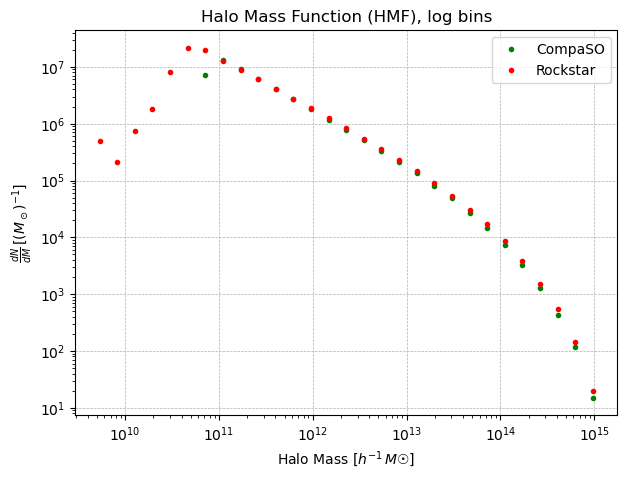

In [13]:
data_hmf_tot = [hmf_cs_log_tot, hmf_rs_log_tot]
bins_hmf_tot = [bin_centers_cs_log_tot, bin_centers_rs_log_tot]

plot_masses_fct(data_hmf_tot, bins_hmf_tot, colors_list, labels_name, linestyles_list=['none','none'], title='Halo Mass Function (HMF), log bins', ylabel=r'$\frac{dN}{dM} \, [(M_\odot)^{-1}]$')

data_hmf = [hmf_cs_log, hmf_rs_log]
bins_hmf = [bin_centers_cs_log, bin_centers_rs_log]

plot_masses_fct(data_hmf, bins_hmf, colors_list, labels_name, linestyles_list=['none','none'], title='Halo Mass Function (HMF), log bins', ylabel=r'$\frac{dN}{dM} \, [(M_\odot)^{-1}]$')

/tmp/ipykernel_886580/1629381842.py:1: RuntimeWarning: divide by zero encountered in divide
  plot_masses_fct([hmf_rs_log / hmf_cs_log],


ValueError: Axis limits cannot be NaN or Inf

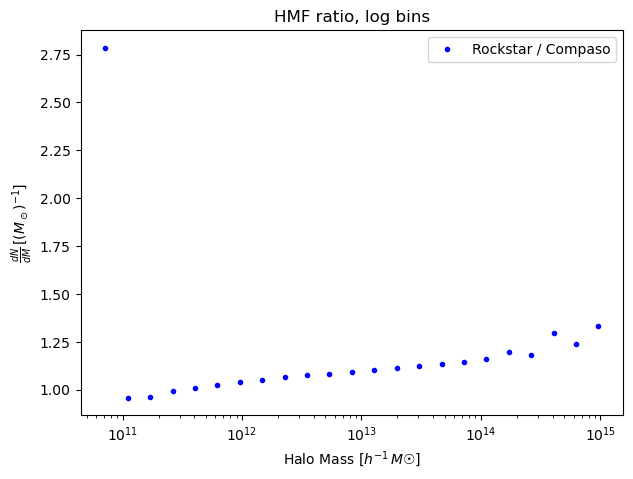

In [14]:
plot_masses_fct([hmf_rs_log / hmf_cs_log], 
                [bin_centers_rs_log], colors_list=colors_ratio, 
                labels_list=labels_ratio, linestyles_list=['none'], 
                scale='semilogx', title='HMF ratio, log bins', 
                ylabel=r'$\frac{dN}{dM} \, [(M_\odot)^{-1}]$',
                center_around_one=True, margin_factor=0.1)

In [ ]:
print(len(Mhalos_RS) / len(Mhalos_CS))

print(np.sum(hmf_rs_log) / np.sum(hmf_cs_log)) 

# Correlation function

In [ ]:
positions_rs = positions_RS % boxsize_cs

x_cs, y_cs, z_cs = positions_cs[:, 0], positions_cs[:, 1], positions_cs[:, 2]
x_rs, y_rs, z_rs = positions_rs[:, 0], positions_rs[:, 1], positions_rs[:, 2]

## SMU

In [ ]:
bins_s = np.linspace(0, 100, 51)  # Distance intervals in Mpc/h
bins_mu = np.linspace(-1, 1, 101)    # Angle cosine intervals

bins_log_s = np.logspace(np.log10(0.01), np.log10(100), 30)

In [ ]:
ells = (0, 2, 4)
wedges = (-1., -2./3, -1./3, 0., 1./3, 2./3, 1.)

### Download

In [ ]:
data_smu_cs = np.load('/pscratch/sd/g/guittonm/smu_cs_rem_all.npz', allow_pickle=True)
 
results_smu_cs = data_smu_cs['results_smu_cs'].item()
rp_cs = data_smu_cs['rp_cs'] 
xi_cs = data_smu_cs['xi_cs']

data_smu_rs = np.load('/pscratch/sd/g/guittonm/smu_rs_rem_all.npz', allow_pickle=True)
 
results_smu_rs = data_smu_rs['results_smu_rs'].item()
rp_rs = data_smu_rs['rp_rs'] 
xi_rs = data_smu_rs['xi_rs']

In [ ]:
data_smu_cs_log = np.load('/pscratch/sd/g/guittonm/smu_log_cs_rem_all.npz', allow_pickle=True)
 
results_smu_cs_log = data_smu_cs_log['results_smu_cs_log'].item()
rp_cs_log = data_smu_cs_log['rp_cs_log'] 
xi_cs_log = data_smu_cs_log['xi_cs_log']

data_smu_rs_log = np.load('/pscratch/sd/g/guittonm/smu_log_rs_rem_all.npz', allow_pickle=True)
 
results_smu_rs_log = data_smu_rs_log['results_smu_rs_log'].item()
rp_rs_log = data_smu_rs_log['rp_rs_log'] 
xi_rs_log = data_smu_rs_log['xi_rs_log']

### Plots

In [ ]:
## CompaSO

results_smu_cs = TwoPointCorrelationFunction(
    mode='smu',  
    edges=(bins_s, bins_mu),  # Distance markers for bins
    data_positions1=(x_cs, y_cs, z_cs),  # Halo positions
    boxsize=boxsize_cs,  
    los='z',
    nthreads=55
)

# Results
xi_cs = results_smu_cs.corr  # Values of 2PCF
rp_cs = results_smu_cs.sep  # Corresponding distances

print('Shape of s :', rp_cs.shape)  # Should be dimension (n,)
print(f'Shape of xi(s) : {xi_cs.shape}')

In [ ]:
print_multipoles(results_smu_cs, ells, title = 'CompaSO')

In [ ]:
## Rockstar

results_smu_rs = TwoPointCorrelationFunction(
    mode='smu',  
    edges=(bins_s, bins_mu),  # Distance markers for bins 
    data_positions1=(x_rs, y_rs, z_rs),  # Halo positions
    boxsize=boxsize_rs,      
    los='z',
    nthreads=55
)   
 
# Results 
xi_rs = results_smu_rs.corr  # Values of 2PCF  
rp_rs = results_smu_rs.sep  # Corresponding distances
 
print('Shape of s :', rp_rs.shape)  # Should be dimension (n,)
print(f'Shape of xi(s) : {xi_rs.shape}')

In [ ]:
print_multipoles(results_smu_rs, ells, title = 'Rockstar')

In [ ]:
results_smu_list = [results_smu_cs, results_smu_rs]
colors_smu = ['deepskyblue', 'lightpink', 'springgreen', 'dodgerblue', 'deeppink', 'seagreen']

print_many_multipoles(results_list=results_smu_list, labels=['CompaSO', 'Rockstar'], colors_list=colors_smu, ells=ells, title='Rockstar vs compaSO')

In [ ]:
np.savez('/pscratch/sd/g/guittonm/smu_cs_rem_all.npz', 
         results_smu_cs=results_smu_cs,
         rp_cs=rp_cs, 
         xi_cs=xi_cs)

np.savez('/pscratch/sd/g/guittonm/smu_rs_rem_all.npz', 
         results_smu_rs=results_smu_rs,
         rp_rs=rp_rs, 
         xi_rs=xi_rs)

### log

In [ ]:
## CompaSO

results_smu_cs_log = TwoPointCorrelationFunction(
    mode='smu',  
    edges=(bins_log_s, bins_mu),  # Distance markers for bins
    data_positions1=(x_cs, y_cs, z_cs),  # Halo positions
    boxsize=boxsize_cs,  
    los='z',
    nthreads=55
)

# Results
xi_cs_log = results_smu_cs_log.corr  # Values of 2PCF
rp_cs_log = results_smu_cs_log.sep  # Corresponding distances

In [ ]:
print_multipoles_log(results_smu_cs_log, ells, title = 'CompaSO - log')

In [ ]:
# np.savez('/pscratch/sd/g/guittonm/smu_log_cs_rem.npz', 
#          results_smu_cs_log=results_smu_cs_log,
#          rp_cs_log=rp_cs_log, 
#          xi_cs_log=xi_cs_log)

In [ ]:
# ## Rockstar

# results_smu_rs_log = TwoPointCorrelationFunction(
#     mode='smu',  
#     edges=(bins_log_s, bins_mu),  # Distance markers for bins
#     data_positions1=(x_rs, y_rs, z_rs),  # Halo positions
#     boxsize=boxsize_rs,  
#     los='z', 
#     nthreads=55
# )    

# # Results 
# xi_rs_log = results_smu_rs_log.corr  # Values of 2PCF 
# rp_rs_log = results_smu_rs_log.sep  # Corresponding distances

In [ ]:
print_multipoles_log(results_smu_rs_log, ells, title = 'Rockstar - log')

In [ ]:
# np.savez('/pscratch/sd/g/guittonm/smu_log_rs_rem.npz', 
#          results_smu_rs_log=results_smu_rs_log,
#          rp_rs_log=rp_rs_log, 
#          xi_rs_log=xi_rs_log)

In [ ]:
results_smu_log_list = [results_smu_cs_log, results_smu_rs_log]
colors_smu = ['deepskyblue', 'lightpink', 'springgreen', 'dodgerblue', 'deeppink', 'seagreen']

print_many_multipoles_log(results_list=results_smu_log_list, labels=['CompaSO', 'Rockstar'], colors_list=colors_smu, ells=ells, title='Rockstar vs compaSO')

In [ ]:
pairs_s_cs = results_smu_cs_log.D1D2.wcounts
pairs_s_rs = results_smu_rs_log.D1D2.wcounts    # Somme sur mu

# Vérification de la forme des données
print("Shape of pairs_s_cs:", pairs_s_cs.shape)
print("Shape of pairs_s_rs:", pairs_s_rs.shape)

# Somme sur mu pour obtenir le nombre de paires par bin de s
pairs_s_cs_summed = np.sum(pairs_s_cs, axis=-1)  
pairs_s_rs_summed = np.sum(pairs_s_rs, axis=-1)

# Création du masque : où la somme des paires n’est pas nulle
mask_nonzero_cs = pairs_s_cs_summed > 0
mask_nonzero_rs = pairs_s_rs_summed > 0

# Appliquer le même masque sur les deux courbes (optionnel, tu peux aussi en faire un pour RS)
s_values_cs = bins_log_s[:-1][mask_nonzero_cs]
pairs_values_cs = pairs_s_cs_summed[mask_nonzero_cs]

s_values_rs = bins_log_s[:-1][mask_nonzero_rs]
pairs_values_rs = pairs_s_rs_summed[mask_nonzero_rs]


# Tracé
plt.figure(figsize=(8,6))
plt.loglog(s_values_cs, pairs_values_cs, label="CompaSO", marker="o", markersize=3, linestyle="-", color='green')
plt.loglog(s_values_rs, pairs_values_rs, label="Rockstar", marker="s", markersize=3, linestyle="-", color = 'red')

plt.xlabel(r"$s$ [Mpc/h]")
plt.ylabel("Number of pairs")
plt.title("Comparison of the number of pairs for each $s$")
plt.legend()
plt.grid(True, which='major', linestyle='--', alpha=0.5)
plt.show()

print(pairs_s_cs_summed[0:9])

## RPPI

### Bins

In [ ]:
# bins_rp = np.linspace(0, 100, 101)  # (0,40,41)
bins_pi = np.linspace(-100, 100, 81)   # (-40,40,81)
bins_rp = np.logspace(np.log10(0.01), np.log10(100), 41) #np.log10(0.01)

### No RSD

In [ ]:
# ## CompaSo

# results_rppi_cs = TwoPointCorrelationFunction(
#     mode='rppi',  
#     edges=(bins_rp, bins_pi),  # Bornes des distances pour les bins
#     data_positions1=(x_cs, y_cs, z_cs),  # Positions des halos
#     nthreads=55,
#     boxsize=boxsize_cs,
#     los='z'
# )

# pi_cs = results_rppi_cs.sepavg(axis=1)
# xi_rppi_cs = results_rppi_cs.corr

In [ ]:
# np.savez('/pscratch/sd/g/guittonm/rppi_cs_rem.npz', 
#          results_rppi_cs=results_rppi_cs,
#          pi_cs=pi_cs, 
#          xi_rppi_cs=xi_rppi_cs)

data_rppi_cs = np.load('/pscratch/sd/g/guittonm/rppi_cs_rem.npz', allow_pickle=True)

results_rppi_cs = data_rppi_cs['results_rppi_cs'].item()
pi_cs = data_rppi_cs['pi_cs']
xi_rppi_cs = data_rppi_cs['xi_rppi_cs']

In [ ]:
sep_cs = projected_pcf(results_rppi_cs, title='CompaSO')

In [ ]:
# ## Rockstar
 
# results_rppi_rs = TwoPointCorrelationFunction(
#     mode='rppi',  
#     edges=(bins_rp, bins_pi),  # Bornes des distances pour les bins
#     data_positions1=(x_rs, y_rs, z_rs),  # Positions des halos
#     nthreads=55,
#     boxsize=boxsize_cs, 
#     los='z'
# )

# pi_rs = results_rppi_rs.sepavg(axis=1)
# xi_rppi_rs = results_rppi_rs.corr

In [ ]:
# np.savez('/pscratch/sd/g/guittonm/rppi_rs_pid_rem.npz', 
#          results_rppi_rs=results_rppi_rs,
#          pi_rs=pi_rs, 
#          xi_rppi_rs=xi_rppi_rs)

data_rppi_rs = np.load('/pscratch/sd/g/guittonm/rppi_rs_pid_rem.npz', allow_pickle=True)

results_rppi_rs = data_rppi_rs['results_rppi_rs'].item()
pi_rs = data_rppi_rs['pi_rs']
xi_rppi_rs = data_rppi_rs['xi_rppi_rs']

In [ ]:
sep_rs = projected_pcf(results_rppi_rs, title='Rockstar')

In [ ]:
sep_rs, wp_rs = results_rppi_rs(pimax=None, return_sep=True) # sep is r_p
sep_cs, wp_cs = results_rppi_cs(pimax=None, return_sep=True)

plt.figure(figsize=(7, 5))
plt.title(f'Projected Correlation Function')

# Plot CompaSO
plt.plot(sep_cs, sep_cs * wp_cs, label='CompaSO', color='green', linestyle='-')

# Plot Rockstar
plt.plot(sep_rs, sep_rs * wp_rs, label='Rockstar', color='red', linestyle='-')

# Axes and labels
plt.xscale('log')
plt.xlabel(r'$r_{p}$')
plt.ylabel(r'$r_{p} w_{p}(r_{p})$')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.show()

### RSD

In [ ]:
## CompaSO

z_sim_cs = hcat.header['Redshift']
id_cs = np.array(hcat_pos['id'])
a_cs = hcat.header['ScaleFactor'] # scale factor

Hz_cs = hcat.header['HubbleNow'] * 100

velocities_cs = np.array(hcat_pos['v_L2com'])[isolated_mask]

z_rsd_cs, delta_z_cs = rsd_effect(a_cs, positions_cs, velocities_cs, Hz_cs, name='CompaSO')

## Rockstar

H0 = 100
Om_rs = get_variable(file_path_rs, name='Om')
Ol_rs = get_variable(file_path_rs, name='Ol')
z_sim_rs = extract_redshift_from_path(file_path_rs)
a_rs = Ol_rs = get_variable(file_path_rs, name='SCALE_NOW')

Hz_rs = H0 * np.sqrt(Om_rs * (1+z_sim_rs)**3 + Ol_rs)

print('Hz :', Hz_rs, '\n', 'Om_rs :', Om_rs, '\n', 'Ol_rs :', Ol_rs, '\n', 'z_sim_rs :', z_sim_rs, '\n', 'a_rs :', a_rs, '\n',)

z_rsd_rs, delta_z_rs = rsd_effect(a_rs, positions_rs, velocities_RS, Hz_rs, name='Rockstar')

In [ ]:
# ## CompaSo
 
# results_rppi_cs_rsd = TwoPointCorrelationFunction(
#     mode='rppi',  
#     edges=(bins_rp, bins_pi),  # Bornes des distances pour les bins
#     data_positions1=(x_cs, y_cs, z_rsd_cs),  # Positions des halos
#     nthreads=55,
#     boxsize=boxsize_cs,
#     los='z'
# )

# pi_cs_rsd = results_rppi_cs_rsd.sepavg(axis=1) 
# xi_rppi_cs_rsd = results_rppi_cs_rsd.corr

In [ ]:
# np.savez('/pscratch/sd/g/guittonm/rppi_cs_rsd_rem.npz', 
#          results_rppi_cs_rsd=results_rppi_cs_rsd,
#          pi_cs_rsd=pi_cs_rsd, 
#          xi_rppi_cs_rsd=xi_rppi_cs_rsd)

data_rppi_cs_rsd = np.load('/pscratch/sd/g/guittonm/rppi_cs_rsd_rem.npz', allow_pickle=True)

results_rppi_cs_rsd = data_rppi_cs_rsd['results_rppi_cs_rsd'].item()
pi_cs_rsd = data_rppi_cs_rsd['pi_cs_rsd']
xi_rppi_cs_rsd = data_rppi_cs_rsd['xi_rppi_cs_rsd']

In [ ]:
sep_cs_rsd = projected_pcf(results_rppi_cs_rsd, title='CompaSO RSD')

In [ ]:
## Rockstar

results_rppi_rs_rsd = TwoPointCorrelationFunction(
    mode='rppi',  
    edges=(bins_rp, bins_pi),  # Bornes des distances pour les bins
    data_positions1=(x_rs, y_rs, z_rsd_rs),  # Positions des halos
    nthreads=55,  
    boxsize=boxsize_rs,
    los='z'
) 
 
pi_rs_rsd = results_rppi_rs_rsd.sepavg(axis=1)
xi_rppi_rs_rsd = results_rppi_rs_rsd.corr 

In [ ]:
np.savez('/pscratch/sd/g/guittonm/rppi_rs_rsd_pid_rem.npz', 
         results_rppi_rs_rsd=results_rppi_rs_rsd,
         pi_rs_rsd=pi_rs_rsd, 
         xi_rppi_rs_rsd=xi_rppi_rs_rsd)

data_rppi_rs_rsd = np.load('/pscratch/sd/g/guittonm/rppi_rs_rsd_pid_rem.npz', allow_pickle=True)

results_rppi_rs_rsd = data_rppi_rs_rsd['results_rppi_rs_rsd'].item()
pi_rs_rsd = data_rppi_rs_rsd['pi_rs_rsd']
xi_rppi_rs_rsd = data_rppi_rs_rsd['xi_rppi_rs_rsd']

In [ ]:
sep_rs_rsd = projected_pcf(results_rppi_rs_rsd, title='Rockstar RSD')

In [ ]:
pcf_results = [results_rppi_rs, results_rppi_cs, results_rppi_rs_rsd, results_rppi_cs_rsd]
legends_pcf = ['Rockstar', 'CompaSo', 'Rockstar RSD', 'CompaSo RSD']
colors_pcf= ['red', 'green', 'pink', 'limegreen']

compa_pcf(pcf_results, legends=legends_pcf, colors=colors_pcf, title="Projected 2PCF comparison", mask_range=(0.01,100))

# Bias

In [ ]:
file_path = "/pscratch/sd/g/guittonm/all_positions.npy"

# Same positions for both simulations
positions_mm = np.load(file_path, mmap_mode='r')  # mmap_mode for huge data
print(f"Total positions : {positions_mm.shape[0]}")

In [ ]:
# fraction = 0.02  # % of the data

# # Create a binary mask to select 10% of the data
# mask = np.random.rand(positions_mm.shape[0]) < fraction
 
# # Apply the mask
# positions_mm_sampled = positions_mm[mask]

# if positions_mm_sampled.shape[1] == 3:  # Check that it's a 2D table with 3 columns
#     positions_mm_sampled = [positions_mm_sampled[:, 0], positions_mm_sampled[:, 1], positions_mm_sampled[:, 2]]  # Separate x, y, z

In [ ]:
# np.savez('/pscratch/sd/g/guittonm/pos_mm_rem.npz', 
#          positions_mm_sampled=positions_mm_sampled)    
 
data_pos_mm = np.load('/pscratch/sd/g/guittonm/pos_mm_rem.npz') 
 
positions_mm_sampled = data_pos_mm['positions_mm_sampled'] 

In [ ]:
# ## SMU

# results_smu_mm = TwoPointCorrelationFunction(
#     mode='smu',  
#     edges=(bins_s, bins_mu),  # Distance markers for bins
#     data_positions1=positions_mm_sampled,  # Particles positions
#     boxsize=boxsize_cs,  
#     los='z',
#     nthreads=55
# )

# xi_mm = results_smu_mm.corr  

In [ ]:
# np.savez('/pscratch/sd/g/guittonm/smu_mm_rem.npz',  
#          results_smu_mm=results_smu_mm,
#          xi_mm=xi_mm)    
 
data_smu_mm = np.load('/pscratch/sd/g/guittonm/smu_mm_rem.npz', allow_pickle=True)
 
results_smu_mm = data_smu_mm['results_smu_mm'].item()  
xi_mm = data_smu_mm['xi_mm'] 

In [ ]:
r_mm_mono, xi_mm_mono = results_smu_mm(ells=(0,), return_sep=True)

In [ ]:
r_cs_quad, xi_cs_quad = results_smu_cs(ells=(2,), return_sep=True)
r_rs_quad, xi_rs_quad = results_smu_rs(ells=(2,), return_sep=True)
r_mm_quad, xi_mm_quad = results_smu_mm(ells=(2,), return_sep=True)

In [ ]:
print_chosen_multipole(
    [r_cs_quad, r_rs_quad, r_mm_quad], 
    [xi_cs_quad, xi_rs_quad, xi_mm_quad], 
    ["CompaSO", "Rockstar", "Particles"], 
    "Quadrupoles",
    colors_list = ['green', 'red', 'blue']
)

plot_multipole_ratio(r_cs_quad, xi_cs_quad, xi_rs_quad, yrange=None, mask_range=None, l='2', title = "Ratio between CompaSO and Rockstar Quadrupoles", label=r"$\xi_{\mathrm{Rockstar}} / \xi_{\mathrm{CompaSo}}$")

### Bins

In [ ]:
bin_edges_exp = [11.5, 11.75, 12, 12.5, 13, 15.5]

mass_bins = np.power(10, bin_edges_exp)

In [ ]:
# print('CompaSo')
# bias_mono_cs, bias_quad_cs = bias_wrt_mass(mass_bins, Mhalos_CS, positions_cs, bins_s, bins_mu, boxsize_cs, xi_mm_mono, xi_mm_quad, mask_range=(None,None), save_path="/pscratch/sd/g/guittonm/xi_hh_mass_bins_cs_rem.npz")
# print('\n', 'Rockstar')
# bias_mono_rs, bias_quad_rs = bias_wrt_mass(mass_bins, Mhalos_RS, positions_rs, bins_s, bins_mu, boxsize_rs, xi_mm_mono, xi_mm_quad, mask_range=(None,None), save_path="/pscratch/sd/g/guittonm/xi_hh_mass_bins_rs_rem.npz")

In [ ]:
# Charger le fichier _pid.npz
data_cs = np.load("/pscratch/sd/g/guittonm/xi_hh_mass_bins_cs_rem.npz")
data_rs = np.load("/pscratch/sd/g/guittonm/xi_hh_mass_bins_rs_rem.npz")

# Afficher les clés du fichier pour voir ce qu'il contient
print(data_cs.files)
print(data_rs.files)

# Extraire les données
mass_bins_cs = data_cs["mass_bins"]  # Bins de masse
r_hh_cs = data_cs["r_hh_all"]  # Valeurs de r pour chaque bin
xi_hh_mono_cs = data_cs["xi_hh_mono_all"]  # 2PCF monopole pour chaque bin
bias_by_r_mono_cs = data_cs["bias_by_r_mono_all"]
bias_mono_cs =  data_cs["bias_by_mass_mono"]

mass_bins_rs = data_rs["mass_bins"]  # Bins de masse
r_hh_rs = data_rs["r_hh_all"]  # Valeurs de r pour chaque bin
xi_hh_mono_rs = data_rs["xi_hh_mono_all"]  # 2PCF monopole pour chaque bin
bias_by_r_mono_rs = data_rs["bias_by_r_mono_all"]
bias_mono_rs =  data_rs["bias_by_mass_mono"]

In [ ]:
mass_centers_cs = [item[0] for item in bias_mono_cs]
bias_values_cs = [item[1] for item in bias_mono_cs]

mass_centers_rs = [item[0] for item in bias_mono_rs]
bias_values_rs = [item[1] for item in bias_mono_rs]

plot_masses_fct(data_list = [bias_values_cs, bias_values_rs],
                bins_list = [mass_centers_cs, mass_centers_rs],
                colors_list = colors_list,
                labels_list = labels_name,
                linestyles_list=['-','-'],
                ylabel = r'$b^2(M)$',
                title=r"Mean of $b^2(M)$ / bin",
                scale = 'semilogx', center_around_one=False)

np_bias_values_rs = np.array(bias_values_rs)
np_bias_values_cs = np.array(bias_values_cs)

bias_ratio = np_bias_values_rs / np_bias_values_cs

plot_masses_fct(data_list = [bias_ratio],
                bins_list = [mass_centers_rs],
                colors_list = colors_ratio,
                labels_list = labels_ratio,
                linestyles_list=['-'],
                ylabel = r'$b^2_{\mathrm{RS}} \,/\, b^2_{\mathrm{CS}}$',
                title = r"Ratio $b^2(M)$",
                scale = 'semilogx', center_around_one=True)

In [ ]:
## CompaSo

plot_mass_binned_quantity(
    r_hh_all=r_hh_cs, 
    quantity_all=xi_hh_mono_cs,  
    mass_bins=mass_bins,
    ylabel=r'$r^2 \xi_{0}(r)$',
    title='2PCF Monopoles by Mass Bins - CompaSo',
    apply_transformation=lambda r, q: r * r * q.squeeze(),  # Transformation spécifique pour la 2PCF
    mask_range=(0,100),
    yrange=(-15,100),
    scalex=None,
    scaley=None
)

## Rockstar 

plot_mass_binned_quantity(
    r_hh_all=r_hh_rs, 
    quantity_all=xi_hh_mono_rs,  
    mass_bins=mass_bins,
    ylabel=r'$r^2 \xi_{0}(r)$',
    title='2PCF Monopoles by Mass Bins - Rockstar',
    apply_transformation=lambda r, q: r * r * q.squeeze(),  # Transformation spécifique pour la 2PCF
    mask_range=(0,100),
    yrange=(-15,100),
    scalex=None,
    scaley=None
)

In [ ]:
plot_mass_ratio_comparison(
    r_hh_all_cs=r_hh_cs, quantity_all_cs=xi_hh_mono_cs, errors_cs=False,
    r_hh_all_rs=r_hh_rs, quantity_all_rs=xi_hh_mono_rs, errors_rs=False,
    mass_bins=mass_bins, bin_edges_exp=bin_edges_exp,
    ylabel=r'$r^2 \xi_{0}(r)$',
    title="Halo 2PCF Comparison: CompaSo vs Rockstar, smu, 100%",
    apply_transformation=lambda r, q: r * r * q.squeeze(),  # Transformation pour la 2PCF
    rows=2,  # Affichage sur 2 lignes,
    mask_range=(0,100), ratio_yrange=(0.7,1.3),
    scaley=None, scalex=None,
    ratio_leg='upper left', leg_pos='lower left'
)

In [ ]:
plot_mass_ratio_comparison(
    r_hh_all_cs=r_hh_cs, quantity_all_cs=xi_hh_mono_cs, errors_cs=False,
    r_hh_all_rs=r_hh_rs, quantity_all_rs=xi_hh_mono_rs, errors_rs=False,
    mass_bins=mass_bins, bin_edges_exp=bin_edges_exp,
    ylabel=r'$r^2 \xi_{0}(r)$',
    title="Halo 2PCF Comparison: CompaSo vs Rockstar",
    apply_transformation=lambda r, q: r * r * q.squeeze(),  # Transformation pour la 2PCF
    rows=2,  # Affichage sur 2 lignes,
    mask_range=(0,80), ratio_yrange=(0.8,1.2),
    scaley=None, scalex='log',
    ratio_leg='upper left', leg_pos='lower left'
)

In [ ]:
plot_ratio_comparison(
    r_hh_all_cs=r_hh_cs, quantity_all_cs=xi_hh_mono_cs,
    r_hh_all_rs=r_hh_rs, quantity_all_rs=xi_hh_mono_rs,
    mass_bins=mass_bins, bin_edges_exp=bin_edges_exp,
    ylabel=r'$\xi_{\mathrm{RS}} / \xi_{\mathrm{CS}}$',
    title="Halo 2PCF Ratio: CompaSo vs Rockstar",
    apply_transformation=lambda r, q: r * r * q.squeeze(),
    yrange=(0.5, 1.8),
    mask_range=(0,80),
    rows=2  # Affichage sur 2 lignes
)

In [ ]:
## CompaSo
plot_mass_binned_quantity(
    r_hh_all=r_hh_cs, 
    quantity_all=bias_by_r_mono_cs,  
    mass_bins=mass_bins,
    ylabel=r'$b^2(M)$',
    title='Halo Bias wrt r - CompaSo',
    mask_range=(0,80),
    yrange=(-5,15),
    scalex=None,
    scaley=None
)

## Rockstar
plot_mass_binned_quantity(
    r_hh_all=r_hh_rs, 
    quantity_all=bias_by_r_mono_rs,  
    mass_bins=mass_bins,
    ylabel=r'$b^2(M)$',
    title='Halo Bias wrt r - Rockstar',
    mask_range=(0,80),
    yrange=(-5,20),
    scalex=None,
    scaley=None
)

In [ ]:
plot_mass_ratio_comparison(
    r_hh_all_cs=r_hh_cs, quantity_all_cs=bias_by_r_mono_cs, errors_cs=False,
    r_hh_all_rs=r_hh_rs, quantity_all_rs=bias_by_r_mono_rs, errors_rs=False,
    mass_bins=mass_bins, bin_edges_exp=bin_edges_exp,
    ylabel=r'$b^2(M)$',
    title="Halo Bias Comparison: CompaSo vs Rockstar",
    rows=2, scaley=None,
    yrange = (0, 14), ratio_yrange=(0.8,1.2),
    mask_range = (0, 75), leg_pos='upper left', ratio_leg='upper right'
)

In [ ]:
plot_ratio_comparison(
    r_hh_all_cs=r_hh_cs, quantity_all_cs=bias_by_r_mono_cs,
    r_hh_all_rs=r_hh_rs, quantity_all_rs=bias_by_r_mono_rs,
    mass_bins=mass_bins, bin_edges_exp=bin_edges_exp,
    ylabel=r'$b^2_{\mathrm{RS}} / b^2_{\mathrm{CS}}$',
    title="Halo Bias Ratio: CompaSo vs Rockstar",
    yrange=(0.8, 1.8),
    mask_range=(0,75),
    rows=2  # Affichage sur 2 lignes
)

## RPPI wrt mass bin

In [ ]:
# wp_cs, rp_cs = xi_wrt_mass(mass_bins, Mhalos_CS, positions_cs, bins_rp, bins_pi, boxsize_cs, save_path="/pscratch/sd/g/guittonm/rppi_mass_bins_cs_bs_rem.npz", mask_range=(None, None), nthreads=55)

# wp_rs, rp_rs = xi_wrt_mass(mass_bins, Mhalos_RS, positions_rs, bins_rp, bins_pi, boxsize_cs, save_path="/pscratch/sd/g/guittonm/rppi_mass_bins_rs_bs_rem.npz", mask_range=(None, None), nthreads=55)

In [ ]:
# Charger le fichier _pid.npz
data_cs_rppi = np.load("/pscratch/sd/g/guittonm/rppi_mass_bins_cs_bs_rem.npz")
data_rs_rppi = np.load("/pscratch/sd/g/guittonm/rppi_mass_bins_rs_bs_rem.npz")

# Afficher les clés du fichier pour voir ce qu'il contient
print(data_cs_rppi.files)
print(data_rs_rppi.files)

# Extraire les données
mass_bins_cs_rppi = data_cs_rppi["mass_bins"]  # Bins de masse
rp_cs = data_cs_rppi["rp_all"] 
wp_cs = data_cs_rppi["wp_all"] 

mass_bins_rs_rppi = data_rs_rppi["mass_bins"]  # Bins de masse
rp_rs = data_rs_rppi["rp_all"]  
wp_rs = data_rs_rppi["wp_all"]

In [ ]:
plot_mass_binned_quantity(
    r_hh_all=rp_all_cs, 
    quantity_all=wp_all_cs,  
    mass_bins=mass_bins,
    scaley=None,
    ylabel=r'$r_{p} w_{p}(r_{p})$',
    title='2PCF Monopoles by Mass Bins - CompaSo',
    apply_transformation=lambda r, q: r * q.squeeze()  # Transformation spécifique pour la 2PCF
)

plot_mass_binned_quantity(
    r_hh_all=rp_all_rs, 
    quantity_all=wp_all_rs,  
    mass_bins=mass_bins,
    scaley=None,
    ylabel=r'$r_{p} w_{p}(r_{p})$',
    title='2PCF Monopoles by Mass Bins - Rockstar',
    apply_transformation=lambda r, q: r * q.squeeze()  # Transformation spécifique pour la 2PCF
)

In [ ]:
plot_mass_ratio_comparison(
    r_hh_all_cs=rp_cs, quantity_all_cs=wp_cs, errors_cs = False,
    r_hh_all_rs=rp_rs, quantity_all_rs=wp_rs, errors_rs = False,
    mass_bins=mass_bins, bin_edges_exp=bin_edges_exp,
    ylabel=r'$r_{p} w_{p}(r_{p})$',
    title="Projected PCF CompaSo vs Rockstar, rppi, 100%",
    rows=2,
    apply_transformation=lambda r, q: r * q.squeeze(),
    scalex='log',
    scaley=None, ratio_yrange=(0.8,1.2), ratio_leg='upper left', leg_pos='upper center'
)

In [ ]:
## RSD

positions_cs_rsd = np.vstack((x_cs, y_cs, z_rsd_cs)).T
positions_rs_rsd = np.vstack((x_rs, y_rs, z_rsd_rs)).T

# wp_cs_rsd, rp_cs_rsd = xi_wrt_mass(mass_bins, Mhalos_CS, positions_cs_rsd, bins_rp, bins_pi, boxsize_cs, save_path="/pscratch/sd/g/guittonm/rppi_mass_bins_cs_rsd_rem.npz", mask_range=(None, None), nthreads=55)
# wp_rs_rsd, rp_rs_rsd = xi_wrt_mass(mass_bins, Mhalos_RS, positions_rs_rsd, bins_rp, bins_pi, boxsize_cs, save_path="/pscratch/sd/g/guittonm/rppi_mass_bins_rs_rsd_rem.npz", mask_range=(None, None), nthreads=55)

In [ ]:
# Charger le fichier _pid.npz
data_cs_rppi_rsd = np.load("/pscratch/sd/g/guittonm/rppi_mass_bins_cs_rsd_rem.npz")
data_rs_rppi_rsd = np.load("/pscratch/sd/g/guittonm/rppi_mass_bins_rs_rsd_rem.npz")

# Afficher les clés du fichier pour voir ce qu'il contient
print(data_cs_rppi_rsd.files)
print(data_rs_rppi_rsd.files)

# Extraire les données
mass_bins_cs_rppi_rsd = data_cs_rppi_rsd["mass_bins"]  # Bins de masse
rp_cs_rsd = data_cs_rppi_rsd["rp_all"] 
wp_cs_rsd = data_cs_rppi_rsd["wp_all"] 

mass_bins_rs_rppi_rsd = data_rs_rppi_rsd["mass_bins"]  # Bins de masse
rp_rs_rsd = data_rs_rppi_rsd["rp_all"]  
wp_rs_rsd = data_rs_rppi_rsd["wp_all"]

In [ ]:
plot_mass_binned_quantity(
    r_hh_all=rp_cs_rsd, 
    quantity_all=wp_cs_rsd,  
    mass_bins=mass_bins,
    scaley=None,
    ylabel=r'$r_{p} w_{p}(r_{p})$',
    title='2PCF Monopoles by Mass Bins RSD - CompaSo',
    apply_transformation=lambda r, q: r * q.squeeze()  # Transformation spécifique pour la 2PCF
)

plot_mass_binned_quantity(
    r_hh_all=rp_rs_rsd, 
    quantity_all=wp_rs_rsd,  
    mass_bins=mass_bins,
    scaley=None,
    ylabel=r'$r_{p} w_{p}(r_{p})$',
    title='2PCF Monopoles by Mass Bins RSD - Rockstar',
    apply_transformation=lambda r, q: r * q.squeeze()  # Transformation spécifique pour la 2PCF
)

In [ ]:
plot_mass_ratio_comparison(
    r_hh_all_cs=rp_cs_rsd, quantity_all_cs=wp_cs_rsd, errors_cs = False,
    r_hh_all_rs=rp_rs_rsd, quantity_all_rs=wp_rs_rsd, errors_rs = False,
    mass_bins=mass_bins, bin_edges_exp=bin_edges_exp,
    ylabel=r'$r_{p} w_{p}(r_{p})$',
    title="Projected PCF CompaSo vs Rockstar - RSD - 100%",
    rows=2,
    apply_transformation=lambda r, q: r * q.squeeze(),
    scalex='log', ratio_yrange=(0.8,1.2),
    scaley=None, leg_pos='upper right', ratio_leg='upper center'
)

### Bootstrap

In [ ]:
# print('CompaSo')
# bias_mono_cs_bs, bias_quad_cs_bs = bootstrap_bias_wrt_mass(mass_bins, Mhalos_CS, positions_cs, bins_s, bins_mu, boxsize_cs, xi_mm_mono, xi_mm_quad, mask_range=(None,None), save_path="/pscratch/sd/g/guittonm/xi_hh_mass_bins_cs_bs_rem.npz")
# print('\n', 'Rockstar')
# bias_mono_rs_bs, bias_quad_rs_bs = bootstrap_bias_wrt_mass(mass_bins, Mhalos_RS, positions_rs, bins_s, bins_mu, boxsize_rs, xi_mm_mono, xi_mm_quad, mask_range=(None,None), save_path="/pscratch/sd/g/guittonm/xi_hh_mass_bins_rs_bs_rem.npz")

In [ ]:
# Charger le fichier _pid.npz
data_cs_bs = np.load("/pscratch/sd/g/guittonm/xi_hh_mass_bins_cs_bs_rem.npz")
data_rs_bs = np.load("/pscratch/sd/g/guittonm/xi_hh_mass_bins_rs_bs_rem.npz")

# Afficher les clés du fichier pour voir ce qu'il contient
print(data_cs_bs.files)
print(data_rs_bs.files)
 
## CompaSo 
mass_bins_cs_bs = data_cs_bs["mass_bins"]  # Bins de masse 
r_hh_cs_bs = data_cs_bs["r_hh_all"]  # Valeurs de r pour chaque bin
  
xi_hh_mono_cs_bs = data_cs_bs["xi_hh_mono_all"]  # 2PCF monopole pour chaque bin 
xi_hh_quad_cs_bs = data_cs_bs["xi_hh_quad_all"]

bias_by_r_mono_cs_bs = data_cs_bs["bias_by_r_mono_all"]
bias_by_r_quad_cs_bs = data_cs_bs["bias_by_r_quad_all"] 

mean_bias_mono_cs_bs =  data_cs_bs["mean_bias_mono_all"]
mean_bias_quad_cs_bs =  data_cs_bs["mean_bias_mono_all"]  

## Rockstar 

mass_bins_rs_bs = data_rs_bs["mass_bins"]  # Bins de masse
r_hh_rs_bs = data_rs_bs["r_hh_all"]  # Valeurs de r pour chaque bin
 
xi_hh_mono_rs_bs = data_rs_bs["xi_hh_mono_all"]  # 2PCF monopole pour chaque bin 
xi_hh_quad_rs_bs = data_rs_bs["xi_hh_quad_all"]

bias_by_r_mono_rs_bs = data_rs_bs["bias_by_r_mono_all"]
bias_by_r_quad_rs_bs = data_rs_bs["bias_by_r_quad_all"]

mean_bias_mono_rs_bs =  data_rs_bs["mean_bias_mono_all"]
mean_bias_quad_rs_bs =  data_rs_bs["mean_bias_mono_all"]

In [ ]:
plot_mass_comparison(
    r_hh_all_cs=r_hh_cs_bs, quantity_all_cs=mean_bias_mono_cs_bs, errors_cs = True,
    r_hh_all_rs=r_hh_rs_bs, quantity_all_rs=mean_bias_mono_rs_bs, errors_rs = True,
    mass_bins=mass_bins, bin_edges_exp=bin_edges_exp,
    ylabel=r'$b^2(M)$',
    title="Halo Bias Comparison: CompaSo vs Rockstar",
    rows=2,
    yrange = (-1, 12),
    mask_range=(0,75),
    scalex=None,
    scaley=None
)

In [ ]:
n_bins = len(mass_bins) - 1

bias_values_cs = np.array([np.mean(mean_bias_mono_cs_bs[i][0]) for i in range(n_bins)])
bias_errors_cs = np.array([np.mean(mean_bias_mono_cs_bs[i][1]) for i in range(n_bins)])

bias_values_rs = np.array([np.mean(mean_bias_mono_rs_bs[i][0]) for i in range(n_bins)])
bias_errors_rs = np.array([np.mean(mean_bias_mono_rs_bs[i][1]) for i in range(n_bins)])

# Milieu des bins de masse
bias_masses_cs = 0.5 * (mass_bins[:-1] + mass_bins[1:])
bias_masses_rs = 0.5 * (mass_bins[:-1] + mass_bins[1:])

In [ ]:
plot_masses_fct(data_list = [bias_values_cs, bias_values_rs],
                bins_list = [mass_centers_cs, mass_centers_rs],
                colors_list = colors_list,
                labels_list = labels_name,
                linestyles_list=['-', '-'],
                ylabel = r'$b^2(M)$', 
                title = "Halo Bias vs Mass with Bootstrap Uncertainty",
                scale = 'semilogx',
                errors_list = [bias_errors_cs, bias_errors_rs])

### Bootstrap removing

In [ ]:
print('CompaSo')
bias_mono_cs_bs_rm, bias_quad_cs_bs_rm = removing_bias_wrt_mass(mass_bins, Mhalos_CS, positions_cs, bins_s, bins_mu, boxsize_cs, xi_mm_mono, xi_mm_quad, mask_range=(None,None), save_path="/pscratch/sd/g/guittonm/xi_hh_mass_bins_cs_bs_rm_rem.npz")
print('\n', 'Rockstar')
bias_mono_rs_bs_rm, bias_quad_rs_bs_rm = removing_bias_wrt_mass(mass_bins, Mhalos_RS, positions_rs, bins_s, bins_mu, boxsize_rs, xi_mm_mono, xi_mm_quad, mask_range=(None,None), save_path="/pscratch/sd/g/guittonm/xi_hh_mass_bins_rs_bs_rm_rem.npz")